# What is this for?
This notebook helps us to test our LSTM Models. That way we will create default setup of model parameters. But those will still be changeable within the streamlit application. So this is kind of a helper notebook.

In [1]:
# Import Libraries
import pandas as pd 
import numpy as np 
import plotly.graph_objects as go
import yfinance as yf 
import datetime
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import yfinance as yf 
import datetime as dt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM 



## Model Creating and Testing

Epoch 1/200
7/7 [==============================] - 4s 21ms/step - loss: 0.2703
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 0.1208
Epoch 3/200
7/7 [==============================] - 0s 17ms/step - loss: 0.1051
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 0.0942
Epoch 5/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0863
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0871
Epoch 7/200
7/7 [==============================] - 0s 17ms/step - loss: 0.0745
Epoch 8/200
7/7 [==============================] - 0s 32ms/step - loss: 0.0869
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0812
Epoch 10/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0796
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0716
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0789
Epoch 13/200
7/7 [==============================]

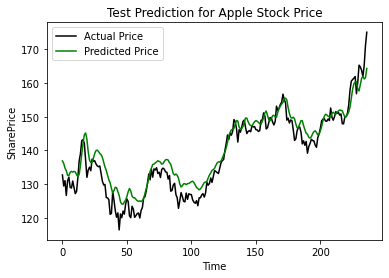

In [62]:


## start date
start = dt.datetime(2020,1,1)

## end date
end = dt.datetime(2021,1,1)

## load data 
apple = yf.download(
        "AAPL", start=start, end=end, progress=False
    )

## Prepare Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(apple["Close"].values.reshape(-1,1))

## window back 
backshift_days = 30 

## Xtarin and y train 
X_train = []
y_train = []

for x in range(backshift_days, len(scaled_data)):
    X_train.append(scaled_data[x-backshift_days:x, 0])
    y_train.append(scaled_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build Model 
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of next closing value 

model.compile(optimizer="adam", loss="mean_absolute_error")

model.fit(X_train, y_train, epochs=200, batch_size=32)

## Test model Accuracy on Existing Data

# Load Test Data
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

apple_test = yf.download(
        "AAPL", start=test_start, end=test_end, progress=False
    )

## actual test prices 
actual_prices = apple_test["Close"].values 

total_dataset = pd.concat((apple["Close"], apple_test["Close"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(apple_test) - backshift_days:].values 
model_inputs = model_inputs.reshape(-1,1) 
model_inputs = scaler.transform(model_inputs)

## Make Predictions on Test Data 

X_test = []

for x in range(backshift_days, len(model_inputs)):
    X_test.append(model_inputs[x-backshift_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

### bring everything together 


# Plot the Test Predictions 
plt.plot(actual_prices, color="black", label="Actual Price")
plt.plot(predicted_prices, color="green", label="Predicted Price")
plt.title("Test Prediction for Apple Stock Price")
plt.xlabel("Time")
plt.ylabel("SharePrice")
plt.legend()
plt.show()





In [63]:
test_range = apple_test[["Close"]]
test_range["Prediction"] = predicted_prices
test_range

/var/folders/w6/3v68jtps1j56v4y_y6bx4z3c0000gn/T/ipykernel_39595/1271414980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_range["Prediction"] = predicted_prices


,Close,Prediction
Date,,
2020-12-31,132.690002,136.881943
2021-01-04,129.410004,136.141296
2021-01-05,131.009995,134.728119
2021-01-06,126.599998,133.954712
2021-01-07,130.919998,132.552231
...,...,...
2021-12-02,163.759995,161.409546
2021-12-03,161.839996,161.994537
2021-12-06,165.320007,161.207428


In [64]:
full = pd.concat([apple[["Close"]], test_range], axis=0)

<AxesSubplot:xlabel='Date'>

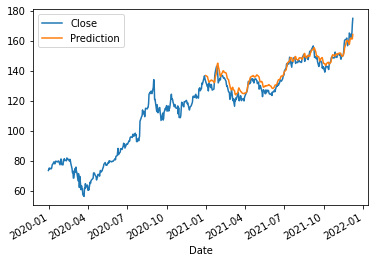

In [65]:
full.plot()

## Now Predicting The day we do not now yet 

In [66]:
real_data=[model_inputs[len(model_inputs)-backshift_days: len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[167.95729]]
